In [206]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold

from imblearn.over_sampling import SMOTE
from sklearn import metrics
from imblearn.metrics import sensitivity_specificity_support

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

import re
%matplotlib inline

# Problem Statement

<b>
Customer retention and mainly retaining high value customers is most important in Telecom industry, as this is a highly competitive market.For this, this analysis:<br>
1) Evaluates models which tries to predict high value customers that are likely to churn<br>
2) Evaluates for important factors that help in identifying customer churn<br>
3) Recommend strategies to maintain customer churn

# Read Data Set.

<b> Please update this path when running on a different system

In [3]:
master_df=pd.read_csv("telecom_churn_data.csv")

In [4]:
master_df.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [5]:
master_df.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [6]:
pd.options.display.max_rows = 300

In [7]:
master_df.shape

(99999, 226)

# Data Cleaning

Deleting 'mobile_number' attributes as it is similar to ID and we already have index to represent each row

In [8]:
master_df=master_df.drop(columns=['mobile_number'])

## Check for NULL and unique attribute values

### Checking for Rows with >90% Null value

In [9]:
for i in range(len(master_df.index)):
    if (100*master_df.iloc[i].isnull().sum()/len(master_df.columns) > 90):
        print("Nan in row ", i , " : " ,  100*master_df.iloc[i].isnull().sum()/len(master_df.columns))

There are no rows with >90% NULL values which are canditates for removal, hence proceeding with addressing NULL values by attribute basis

### Checking for NULL Values in columns

In [10]:
(master_df.isnull().sum()[master_df.isnull().sum()!=0]/master_df.shape[0])*100

loc_og_t2o_mou               1.018010
std_og_t2o_mou               1.018010
loc_ic_t2o_mou               1.018010
last_date_of_month_7         0.601006
last_date_of_month_8         1.100011
last_date_of_month_9         1.659017
onnet_mou_6                  3.937039
onnet_mou_7                  3.859039
onnet_mou_8                  5.378054
onnet_mou_9                  7.745077
offnet_mou_6                 3.937039
offnet_mou_7                 3.859039
offnet_mou_8                 5.378054
offnet_mou_9                 7.745077
roam_ic_mou_6                3.937039
roam_ic_mou_7                3.859039
roam_ic_mou_8                5.378054
roam_ic_mou_9                7.745077
roam_og_mou_6                3.937039
roam_og_mou_7                3.859039
roam_og_mou_8                5.378054
roam_og_mou_9                7.745077
loc_og_t2t_mou_6             3.937039
loc_og_t2t_mou_7             3.859039
loc_og_t2t_mou_8             5.378054
loc_og_t2t_mou_9             7.745077
loc_og_t2m_m

<b> Check for unique values

In [11]:
listi=[(master_df[col].unique(),col) for col in master_df.columns if len(master_df[col].unique())<3]

In [12]:
listi

[(array([109], dtype=int64), 'circle_id'),
 (array([ 0., nan]), 'loc_og_t2o_mou'),
 (array([ 0., nan]), 'std_og_t2o_mou'),
 (array([ 0., nan]), 'loc_ic_t2o_mou'),
 (array(['6/30/2014'], dtype=object), 'last_date_of_month_6'),
 (array(['7/31/2014', nan], dtype=object), 'last_date_of_month_7'),
 (array(['8/31/2014', nan], dtype=object), 'last_date_of_month_8'),
 (array(['9/30/2014', nan], dtype=object), 'last_date_of_month_9'),
 (array([nan,  0.]), 'std_og_t2c_mou_6'),
 (array([nan,  0.]), 'std_og_t2c_mou_7'),
 (array([ 0., nan]), 'std_og_t2c_mou_8'),
 (array([nan,  0.]), 'std_og_t2c_mou_9'),
 (array([nan,  0.]), 'std_ic_t2o_mou_6'),
 (array([nan,  0.]), 'std_ic_t2o_mou_7'),
 (array([ 0., nan]), 'std_ic_t2o_mou_8'),
 (array([nan,  0.]), 'std_ic_t2o_mou_9')]

<b> Above column attributes have a single unique value or NAN with 0 which when replaced makes attributes with unique value.
<br>These unique attributes wont help much in analysis, hence deleting these columns

In [13]:
cols=[it[1] for it in listi]
cols

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'last_date_of_month_9',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'std_og_t2c_mou_9',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'std_ic_t2o_mou_9']

In [14]:
master_df=master_df.drop(columns=cols)

### Now checking for other attributes to impute them accordingly

In [15]:
(master_df.isnull().sum()[master_df.isnull().sum()!=0]/master_df.shape[0])*100

onnet_mou_6                  3.937039
onnet_mou_7                  3.859039
onnet_mou_8                  5.378054
onnet_mou_9                  7.745077
offnet_mou_6                 3.937039
offnet_mou_7                 3.859039
offnet_mou_8                 5.378054
offnet_mou_9                 7.745077
roam_ic_mou_6                3.937039
roam_ic_mou_7                3.859039
roam_ic_mou_8                5.378054
roam_ic_mou_9                7.745077
roam_og_mou_6                3.937039
roam_og_mou_7                3.859039
roam_og_mou_8                5.378054
roam_og_mou_9                7.745077
loc_og_t2t_mou_6             3.937039
loc_og_t2t_mou_7             3.859039
loc_og_t2t_mou_8             5.378054
loc_og_t2t_mou_9             7.745077
loc_og_t2m_mou_6             3.937039
loc_og_t2m_mou_7             3.859039
loc_og_t2m_mou_8             5.378054
loc_og_t2m_mou_9             7.745077
loc_og_t2f_mou_6             3.937039
loc_og_t2f_mou_7             3.859039
loc_og_t2f_m

### Addressing columns till "ic_others_9" (Attributes of Minutes Of Usage and "og_others_6/7/8/9")

Columns till "ic_others_9" values represent numeric values and we can replace these columns with median 

In [16]:
cols_to_replace_median=((master_df.isnull().sum()[master_df.isnull().sum()!=0]/master_df.shape[0])*100)[:108].index

In [17]:
cols_to_replace_median

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9',
       'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'offnet_mou_9',
       'roam_ic_mou_6', 'roam_ic_mou_7',
       ...
       'spl_ic_mou_8', 'spl_ic_mou_9', 'isd_ic_mou_6', 'isd_ic_mou_7',
       'isd_ic_mou_8', 'isd_ic_mou_9', 'ic_others_6', 'ic_others_7',
       'ic_others_8', 'ic_others_9'],
      dtype='object', length=108)

In [18]:
master_df[cols_to_replace_median]=master_df[cols_to_replace_median].fillna(master_df[cols_to_replace_median].median())

### Checking for attributes of Night Pack and fb_User

These attributes are found to have 3 catrgories due to NAN instead of 2 categories 1/0

In [19]:
listi=[(master_df[col].unique(),col) for col in master_df.columns if len(master_df[col].unique())==3]

In [20]:
listi

[(array([ 0., nan,  1.]), 'night_pck_user_6'),
 (array([ 0., nan,  1.]), 'night_pck_user_7'),
 (array([ 0., nan,  1.]), 'night_pck_user_8'),
 (array([nan,  0.,  1.]), 'night_pck_user_9'),
 (array([ 1., nan,  0.]), 'fb_user_6'),
 (array([ 1., nan,  0.]), 'fb_user_7'),
 (array([ 1., nan,  0.]), 'fb_user_8'),
 (array([nan,  1.,  0.]), 'fb_user_9')]

In [21]:
cols_to_be_updated=[it[1] for it in listi]

In [22]:
cols_to_be_updated

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'night_pck_user_9',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'fb_user_9']

In [23]:
master_df[cols_to_be_updated]=master_df[cols_to_be_updated].fillna(0)

### Now addressing remaining attributes(having NULL values are related to data(2g/3g))

In [24]:
(master_df.isnull().sum()[master_df.isnull().sum()!=0]/master_df.shape[0])*100

date_of_last_rech_6          1.607016
date_of_last_rech_7          1.767018
date_of_last_rech_8          3.622036
date_of_last_rech_9          4.760048
date_of_last_rech_data_6    74.846748
date_of_last_rech_data_7    74.428744
date_of_last_rech_data_8    73.660737
date_of_last_rech_data_9    74.077741
total_rech_data_6           74.846748
total_rech_data_7           74.428744
total_rech_data_8           73.660737
total_rech_data_9           74.077741
max_rech_data_6             74.846748
max_rech_data_7             74.428744
max_rech_data_8             73.660737
max_rech_data_9             74.077741
count_rech_2g_6             74.846748
count_rech_2g_7             74.428744
count_rech_2g_8             73.660737
count_rech_2g_9             74.077741
count_rech_3g_6             74.846748
count_rech_3g_7             74.428744
count_rech_3g_8             73.660737
count_rech_3g_9             74.077741
av_rech_amt_data_6          74.846748
av_rech_amt_data_7          74.428744
av_rech_amt_

<b> Checking for validity of NULL values in columns w.r.t volume of data used

In [25]:
print("Check 2g data for 6 month ", master_df[(master_df['count_rech_2g_6'].isnull()) & (master_df['vol_2g_mb_6']!=0)].shape)
print("Check 2g data for 7 month ", master_df[(master_df['count_rech_2g_7'].isnull()) & (master_df['vol_2g_mb_7']!=0)].shape)
print("Check 2g data for 8 month ", master_df[(master_df['count_rech_2g_8'].isnull()) & (master_df['vol_2g_mb_8']!=0)].shape)
print("Check 2g data for 9 month ", master_df[(master_df['count_rech_2g_9'].isnull()) & (master_df['vol_2g_mb_9']!=0)].shape)
print("Check 3g data for 6 month ", master_df[(master_df['count_rech_3g_6'].isnull()) & (master_df['vol_3g_mb_6']!=0)].shape)
print("Check 3g data for 7 month ", master_df[(master_df['count_rech_3g_7'].isnull()) & (master_df['vol_3g_mb_7']!=0)].shape)
print("Check 3g data for 8 month ", master_df[(master_df['count_rech_3g_8'].isnull()) & (master_df['vol_3g_mb_8']!=0)].shape)
print("Check 3g data for 9 month ", master_df[(master_df['count_rech_3g_9'].isnull()) & (master_df['vol_3g_mb_9']!=0)].shape)

Check 2g data for 6 month  (0, 209)
Check 2g data for 7 month  (0, 209)
Check 2g data for 8 month  (0, 209)
Check 2g data for 9 month  (0, 209)
Check 3g data for 6 month  (0, 209)
Check 3g data for 7 month  (0, 209)
Check 3g data for 8 month  (0, 209)
Check 3g data for 9 month  (0, 209)


<b> Above columns/attributes having NULL values are ones where the data usage is not applicable, as Volume of Data used is 0 i.e., Data services are not used.

In [26]:
cols_to_be_updated=((master_df.isnull().sum()[master_df.isnull().sum()!=0]/master_df.shape[0])*100)[8:].index

In [27]:
cols_to_be_updated

Index(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6',
       'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8', 'av_rech_amt_data_9', 'arpu_3g_6', 'arpu_3g_7',
       'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
       'arpu_2g_9'],
      dtype='object')

Replace these columns with 0, as data service is not applicable

In [28]:
master_df[cols_to_be_updated]=master_df[cols_to_be_updated].fillna(0)

### Addressing columns with Date value.

In [29]:
(master_df.isnull().sum()[master_df.isnull().sum()!=0]/master_df.shape[0])*100

date_of_last_rech_6          1.607016
date_of_last_rech_7          1.767018
date_of_last_rech_8          3.622036
date_of_last_rech_9          4.760048
date_of_last_rech_data_6    74.846748
date_of_last_rech_data_7    74.428744
date_of_last_rech_data_8    73.660737
date_of_last_rech_data_9    74.077741
dtype: float64

In [30]:
cols_to_be_dropped=((master_df.isnull().sum()[master_df.isnull().sum()!=0]/master_df.shape[0])*100).index

In [31]:
cols_to_be_dropped

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9'],
      dtype='object')

<b> Date columns are not of much help in analysis, as they done represent any age or any necessary information, hence considering to drop these columns for this analysis approach

In [32]:
master_df=master_df.drop(columns=cols_to_be_dropped)

#### Checking for any remaining NULL values

In [33]:
(master_df.isnull().sum()[master_df.isnull().sum()!=0]/master_df.shape[0])*100

Series([], dtype: float64)

# Creating Derived variables useful for analysis and filtering of data

In [34]:
master_df.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,197.385,214.816,213.803,21.100,34.31,32.33,0.00,29.84,96.31,91.735,...,0,1.0,1.0,1.0,0.0,968,30.4,0.0,101.20,3.58
1,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.840,...,0,0.0,1.0,1.0,0.0,1006,0.0,0.0,0.00,0.00
2,167.690,189.058,210.226,290.714,11.54,55.24,37.26,74.81,143.33,220.590,...,0,0.0,0.0,0.0,1.0,1103,0.0,0.0,4.17,0.00
3,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.010,...,0,0.0,0.0,0.0,0.0,2491,0.0,0.0,0.00,0.00
4,261.636,309.876,238.174,163.426,50.31,149.44,83.89,58.78,76.96,91.880,...,0,0.0,0.0,0.0,0.0,1526,0.0,0.0,0.00,0.00


## Combining 6th and 7th month data as they both represent good phase

In [35]:
columns_6=[colname for colname in master_df.columns if re.search('_6',colname)]

In [36]:
columns_7=[colname for colname in master_df.columns if re.search('_7',colname)]

In [37]:
tmp_6=[re.split("_6",it)[0] for it in columns_6]
tmp_7=[re.split("_7",it)[0] for it in columns_7]

In [38]:
set(tmp_6)-set(tmp_7)

set()

<b> Attributes in 6th month are also present in 7th month. hence we can proceed with taking average of both months data

In [39]:
for it in range(0,len(columns_6)):
    colname=columns_6[it]+'_7'
    master_df[colname]=(master_df[columns_6[it]]+master_df[columns_7[it]])/2

In [40]:
master_df.head()

,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,...,vol_2g_mb_6_7,vol_3g_mb_6_7,arpu_3g_6_7,arpu_2g_6_7,night_pck_user_6_7,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,fb_user_6_7
0,197.385,214.816,213.803,21.100,34.31,32.33,0.00,29.84,96.31,91.735,...,15.725,117.165,212.17,212.170,0.0,0.0,0.0,1.0,0.0,1.0
1,34.047,355.074,268.321,86.285,24.11,78.68,7.68,18.34,15.74,99.840,...,54.035,0.000,0.00,14.305,0.0,0.5,0.0,0.0,0.0,0.5
2,167.690,189.058,210.226,290.714,11.54,55.24,37.26,74.81,143.33,220.590,...,0.000,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
3,221.338,251.102,508.054,389.500,99.91,54.39,310.98,241.71,123.31,109.010,...,0.000,0.000,0.00,0.000,0.0,0.0,0.0,0.0,0.0,0.0
4,261.636,309.876,238.174,163.426,50.31,149.44,83.89,58.78,76.96,91.880,...,0.000,0.000,0.00,0.000,0.0,0.0,0.5,0.0,0.0,0.0


In [41]:
master_df=master_df.drop(columns=columns_6)

In [42]:
master_df=master_df.drop(columns=columns_7)

In [43]:
master_df['june_july_vbc_3g']=master_df['jun_vbc_3g']+master_df['jul_vbc_3g']

In [44]:
master_df=master_df.drop(columns=['jun_vbc_3g','jul_vbc_3g'])

In [45]:
master_df.shape

(99999, 151)

In [46]:
master_df['aon_mon'] = master_df['aon']/30
master_df.drop('aon', axis=1, inplace=True)
master_df['aon_mon'].head()

0    32.266667
1    33.533333
2    36.766667
3    83.033333
4    50.866667
Name: aon_mon, dtype: float64

## Creating additional values needed for analysis

In [47]:
master_df['avg_rech_amnt_6_7']=master_df['total_rech_amt_6_7']/(master_df['total_rech_num_6_7']+0.0000001)

In [48]:
master_df['avg_rech_amnt_8']=master_df['total_rech_amt_8']/(master_df['total_rech_num_8']+0.0000001)

In [49]:
master_df['avg_rech_amnt_9']=master_df['total_rech_amt_9']/(master_df['total_rech_num_9']+0.0000001)

In [50]:
master_df=master_df.drop(columns=['total_rech_amt_6_7','total_rech_amt_8','total_rech_amt_9',
                                'total_rech_num_6_7','total_rech_num_8','total_rech_num_9'])

In [51]:
(master_df.isnull().sum()[master_df.isnull().sum()!=0]/master_df.shape[0])*100

Series([], dtype: float64)

In [52]:
master_df.shape

(99999, 148)

# Filter Data to 0.7 quantile

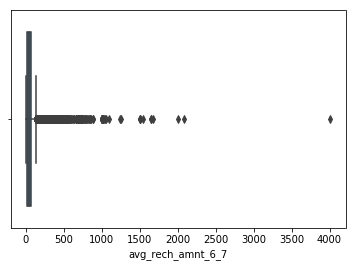

In [53]:
sns.boxplot(master_df['avg_rech_amnt_6_7'])

In [54]:
master_df.avg_rech_amnt_6_7.quantile(0.7)

56.333330704444585

In [55]:
master_df=master_df[master_df.avg_rech_amnt_6_7>=master_df.avg_rech_amnt_6_7.quantile(0.7)]

In [56]:
master_df.shape

(30000, 148)

In [57]:
master_df.head()

,arpu_8,arpu_9,onnet_mou_8,onnet_mou_9,offnet_mou_8,offnet_mou_9,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_8,roam_og_mou_9,...,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,fb_user_6_7,june_july_vbc_3g,aon_mon,avg_rech_amnt_6_7,avg_rech_amnt_8,avg_rech_amnt_9
0,213.803,21.100,0.00,29.84,0.00,87.29,0.00,0.00,0.00,0.00,...,0.0,0.0,1.0,0.0,1.0,101.20,32.266667,87.714283,125.999994,0.000000
7,3171.480,500.000,52.29,29.84,325.91,87.29,31.64,0.00,38.06,0.00,...,0.0,0.0,0.0,0.0,0.0,38.12,26.733333,236.999995,519.714278,0.000000
9,170.231,160.042,22.43,27.84,78.34,123.48,0.00,0.00,0.00,0.00,...,0.5,0.0,0.0,0.0,0.5,0.00,30.066667,69.166664,41.999999,59.999998
13,593.260,322.732,534.24,244.81,482.46,214.06,72.11,136.78,1.44,12.78,...,0.0,0.0,0.0,0.0,0.0,0.00,86.900000,75.999998,65.181818,50.428571
16,187.894,206.490,70.61,31.34,162.76,224.39,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,24.34,17.033333,57.374999,79.999996,219.999978


In [58]:
master_df.shape

(30000, 148)

<b> Left with around 30K rows after filtering >70% customers

# Setting churn Flag For Customers

In [59]:
master_df['churn']=master_df.loc[:,['vol_3g_mb_9','vol_2g_mb_9','total_og_mou_9','total_ic_mou_9']].sum(axis=1).apply(lambda x:1 if x==0 else 0)

In [60]:
master_df['churn'].unique()

array([1, 0], dtype=int64)

In [61]:
master_df.groupby('churn').size()

churn
0    27391
1     2609
dtype: int64

In [62]:
2609/27935*100

9.3395382137104

<b> deleting columns with _9 based on problem statement

In [63]:
churn_phase_cols_to_remove=[colname for colname in master_df.columns if re.search('_9',colname)]

In [64]:
master_df=master_df.drop(columns=churn_phase_cols_to_remove)

In [65]:
master_df.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,...,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,fb_user_6_7,june_july_vbc_3g,aon_mon,avg_rech_amnt_6_7,avg_rech_amnt_8,churn
0,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,1.0,0.0,1.0,101.20,32.266667,87.714283,125.999994,1
7,3171.480,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,...,0.0,0.0,0.0,0.0,0.0,38.12,26.733333,236.999995,519.714278,1
9,170.231,22.43,78.34,0.00,0.00,22.43,34.93,0.00,0.00,57.36,...,0.5,0.0,0.0,0.0,0.5,0.00,30.066667,69.166664,41.999999,0
13,593.260,534.24,482.46,72.11,1.44,36.01,294.46,23.51,0.49,353.99,...,0.0,0.0,0.0,0.0,0.0,0.00,86.900000,75.999998,65.181818,0
16,187.894,70.61,162.76,0.00,0.00,67.38,128.28,10.26,0.00,205.93,...,0.0,0.0,0.0,0.0,0.0,24.34,17.033333,57.374999,79.999996,0


In [66]:
master_df.shape

(30000, 101)

# Checking for Outliers

## Checking for outlier information and visual plots

In [67]:
master_df.describe()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,...,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,fb_user_6_7,june_july_vbc_3g,aon_mon,avg_rech_amnt_6_7,avg_rech_amnt_8,churn
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,443.578770,197.285369,305.083479,12.118643,19.038743,76.333541,151.260935,7.275449,1.216661,235.474246,...,0.149233,0.152883,0.192183,0.064467,0.314200,255.896967,48.081958,96.897349,99.924286,0.086967
std,494.318331,403.051403,435.724733,66.870710,102.768136,204.775893,216.244088,21.000942,5.314222,334.967476,...,0.358027,0.527568,0.537339,0.340070,0.429711,727.471432,34.597695,71.892690,105.157495,0.281791
min,-945.808000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,56.333331,0.000000,0.000000
25%,180.504500,20.190000,78.827500,0.000000,0.000000,6.290000,26.610000,0.000000,0.000000,46.955000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,16.833333,66.666664,49.999995,0.000000
50%,339.972000,61.030000,171.225000,0.000000,0.000000,24.700000,78.870000,0.500000,0.000000,130.760000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37.733333,79.888887,85.666664,0.000000
75%,576.537750,188.265000,376.215000,0.000000,0.000000,75.940000,195.460000,6.030000,0.000000,303.282500,...,0.000000,0.000000,0.000000,0.000000,1.000000,58.317500,79.066667,101.142854,129.999987,0.000000
max,33543.624000,10752.560000,14007.340000,2663.110000,5337.040000,10752.560000,4961.330000,928.490000,303.360000,11039.910000,...,4.500000,10.500000,11.500000,11.000000,1.000000,16381.170000,144.033333,4009.999198,4448.999555,1.000000


In [68]:
master_df.shape

(30000, 101)

## Addressing outlier information by using Skewness and Kertosis values

In [69]:
cols=master_df.columns

In [70]:
list(zip(cols,master_df[cols].skew(),master_df[cols].kurt()))

[('arpu_8', 16.16491537372989, 816.3892429974355),
 ('onnet_mou_8', 6.084245900485547, 71.0840195065337),
 ('offnet_mou_8', 5.988487575650315, 91.52952296950214),
 ('roam_ic_mou_8', 14.318324116866277, 325.8607811270044),
 ('roam_og_mou_8', 15.318331566157635, 429.2307686185923),
 ('loc_og_t2t_mou_8', 15.938653616374047, 537.2696119299003),
 ('loc_og_t2m_mou_8', 4.249457746374237, 36.64038234347519),
 ('loc_og_t2f_mou_8', 10.829218187605727, 248.10257105338619),
 ('loc_og_t2c_mou_8', 14.898762581148041, 499.7776807501784),
 ('loc_og_mou_8', 5.710289354663696, 91.70682236455228),
 ('std_og_t2t_mou_8', 6.449213708486931, 68.39752939788829),
 ('std_og_t2m_mou_8', 9.088775548726796, 183.81736155459384),
 ('std_og_t2f_mou_8', 14.43814509498006, 318.2300467165224),
 ('std_og_mou_8', 5.20092573906892, 54.62877484767726),
 ('isd_og_mou_8', 90.75359695062451, 10386.36995860355),
 ('spl_og_mou_8', 19.319146532430583, 658.7236274344904),
 ('og_others_8', 145.1000176914507, 23029.838661893325),
 (

In [71]:
cols=cols[:-1]

<b> There are variables with high skewness and kurtosis values which can impact PCA and other Regression analysis that will done as part of this analysis, hence addressing these by converting to percentile based variables

In [72]:
master_df[cols]=master_df[cols].rank(pct=True)

In [73]:
list(zip(cols,master_df[cols].skew(),master_df
         [cols].kurt()))

[('arpu_8', 0.00038878665357913896, -1.2009957889380902),
 ('onnet_mou_8', 0.0014955016653463952, -1.2029447814917456),
 ('offnet_mou_8', 0.0004452571379556123, -1.2003378842255579),
 ('roam_ic_mou_8', 1.6647367793748593, 0.8601136238558786),
 ('roam_og_mou_8', 1.6644716506568205, 0.8592521225231406),
 ('loc_og_t2t_mou_8', 0.006842623005929119, -1.214979224939157),
 ('loc_og_t2m_mou_8', 0.002170504179584752, -1.204558944899566),
 ('loc_og_t2f_mou_8', 0.31346029077492404, -1.4631166171903602),
 ('loc_og_t2c_mou_8', 1.5930533160878306, 0.6325713643859925),
 ('loc_og_mou_8', 0.001703293822983462, -1.2034495511869676),
 ('std_og_t2t_mou_8', 0.4156825585613499, -1.4526453476744121),
 ('std_og_t2m_mou_8', 0.09871392248177449, -1.3505355518148758),
 ('std_og_t2f_mou_8', 1.7123807715625934, 1.017321298733695),
 ('std_og_mou_8', 0.04725481050246882, -1.2856452675059098),
 ('isd_og_mou_8', 3.3044316026436906, 8.947800529135204),
 ('spl_og_mou_8', 0.5881434550021571, -1.361438017743885),
 ('og_ot

<b> Skewness and kurtosis values for most of variables is in range, while for some values like 'loc_og_mou_6_7' and 'aon' it is seems to be slightly high, which should be fine and we can re-look if we see issues while modelling process. 
    <br>Continuing for further analysis....

# Visual Analysis of Churn Vs Non-Churn using important features

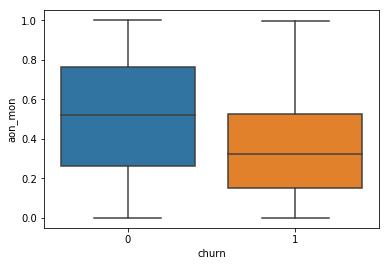

In [74]:
sns.boxplot(x = master_df.churn, y = master_df.aon_mon)

<b> At average Age on network for customers in Non-Churn phase is lower

<b> Action Phase determines users who would churn or wouldn't churn, proceeding to see how these attributes inpact the churn

In [75]:
columns_8=[colname for colname in master_df.columns if re.search('_8',colname)]
grouped_df=master_df.groupby('churn').median()[columns_8]

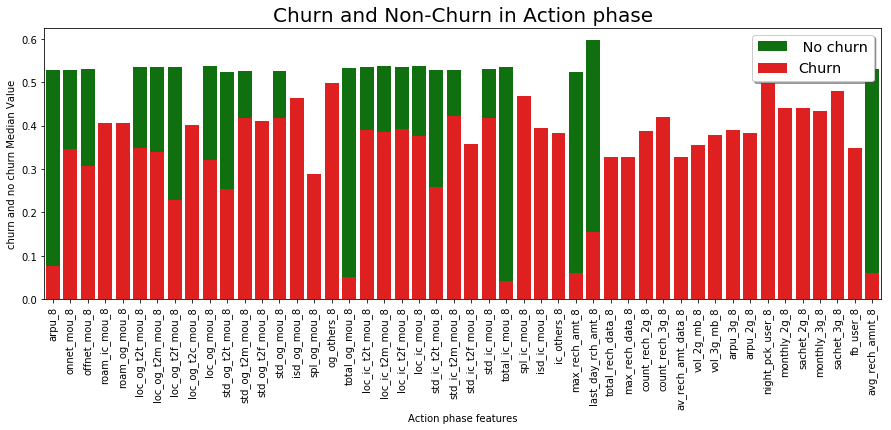

In [76]:
plt.figure(figsize=(15,5))

sns.barplot(x=grouped_df.columns,y=grouped_df.loc[0],color='g',label=" No churn")
ax=sns.barplot(x=grouped_df.columns,y=grouped_df.loc[1],color='r',label="Churn")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.title("Churn and Non-Churn in Action phase",fontsize=20)
plt.xlabel("Action phase features")
plt.ylabel("churn and no churn Median Value")

plt.show()

<b> At Average customers with Churn in "Action" Phase seems to use Data packs more than normal non-churn customers compared to call services

# Checking for correlation between variables

## Correlation matrix for observing relation ship between variables

In [77]:
master_df.corr()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,...,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,fb_user_6_7,june_july_vbc_3g,aon_mon,avg_rech_amnt_6_7,avg_rech_amnt_8,churn
arpu_8,1.000000,0.555506,0.675265,0.106116,0.115568,0.447305,0.496801,0.302147,0.191089,0.518907,...,0.029071,0.127170,0.156411,0.072687,0.152962,0.160249,0.052339,0.236736,0.486279,-0.282776
onnet_mou_8,0.555506,1.000000,0.492651,0.073957,0.087664,0.665049,0.376978,0.153519,0.159324,0.501601,...,-0.131770,0.065896,-0.106864,-0.031905,-0.167627,-0.141184,0.053790,0.066823,0.179441,-0.148229
offnet_mou_8,0.675265,0.492651,1.000000,0.046268,0.056581,0.492072,0.716629,0.328212,0.160601,0.669106,...,-0.115299,0.056309,-0.077951,-0.021740,-0.130890,-0.095494,0.084921,0.139977,0.289846,-0.193841
roam_ic_mou_8,0.106116,0.073957,0.046268,1.000000,0.946995,-0.110749,-0.138298,-0.054310,0.009927,-0.141423,...,-0.036126,0.031946,-0.010208,-0.012023,-0.033463,-0.012015,-0.042513,0.045637,-0.004453,0.131875
roam_og_mou_8,0.115568,0.087664,0.056581,0.946995,1.000000,-0.109677,-0.138599,-0.059146,0.014519,-0.141735,...,-0.039282,0.029722,-0.017176,-0.012067,-0.040947,-0.021257,-0.050495,0.043006,-0.003083,0.140314
loc_og_t2t_mou_8,0.447305,0.665049,0.492072,-0.110749,-0.109677,1.000000,0.678359,0.388962,0.088306,0.838634,...,-0.050674,0.060496,-0.041343,-0.003936,-0.049599,-0.025338,0.222620,0.131167,0.286413,-0.226693
loc_og_t2m_mou_8,0.496801,0.376978,0.716629,-0.138298,-0.138599,0.678359,1.000000,0.488963,0.072363,0.939129,...,-0.048175,0.033373,-0.027284,-0.002405,-0.040853,-0.007686,0.254905,0.163078,0.345552,-0.243092
loc_og_t2f_mou_8,0.302147,0.153519,0.328212,-0.054310,-0.059146,0.388962,0.488963,1.000000,0.020687,0.508890,...,0.018625,0.003507,0.025538,0.013789,0.042073,0.088910,0.279430,0.184535,0.324792,-0.232882
loc_og_t2c_mou_8,0.191089,0.159324,0.160601,0.009927,0.014519,0.088306,0.072363,0.020687,1.000000,0.080433,...,-0.002582,0.079495,0.004425,0.042414,0.018894,0.013835,-0.028439,-0.031336,0.010051,-0.080659
loc_og_mou_8,0.518907,0.501601,0.669106,-0.141423,-0.141735,0.838634,0.939129,0.508890,0.080433,1.000000,...,-0.049813,0.054351,-0.029426,-0.001080,-0.040002,-0.007613,0.260614,0.174675,0.355954,-0.253602


In [78]:
#PLOTTING CORRELATION MATRIX
def plotCorrelationMatrix(df, graphWidth):
    filename = "Telecom Churn"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=30)
    plt.show()

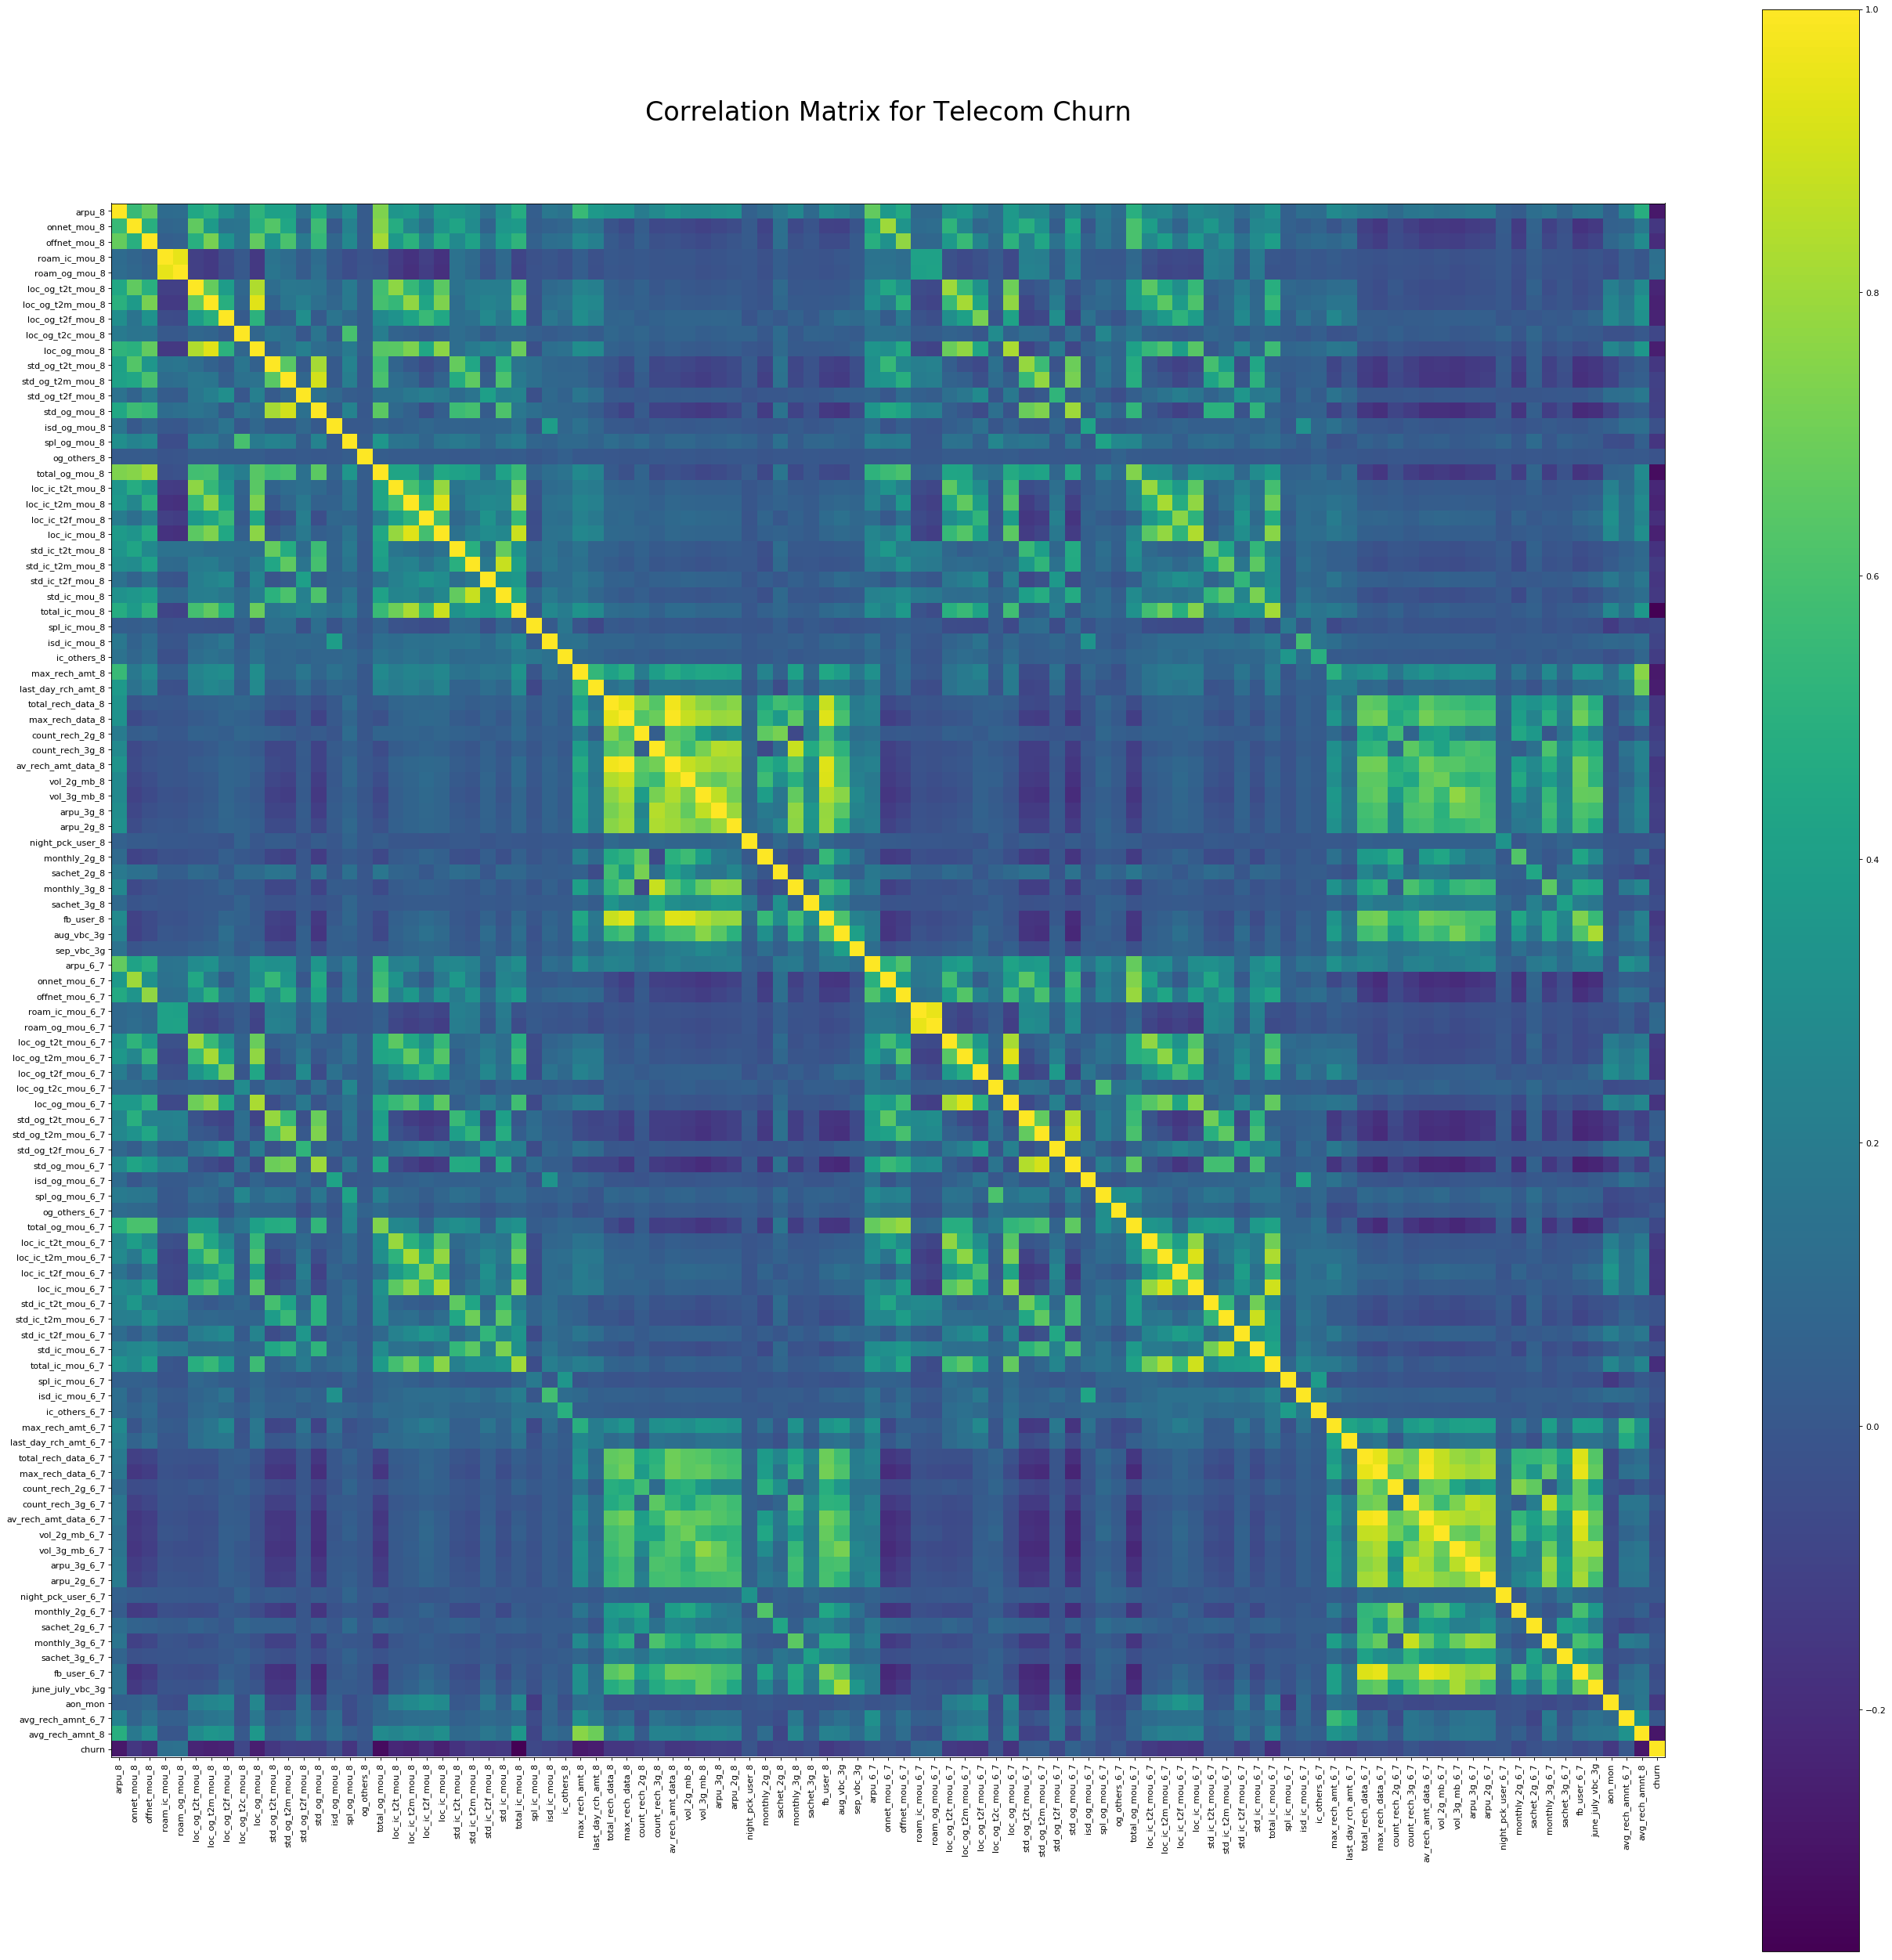

In [79]:
plotCorrelationMatrix(master_df, 40)

<b> Addressing columns having correlation greater than 0.9

In [80]:
corr_matrix = master_df.corr().abs()
high_corr_var=np.where(corr_matrix>=0.9)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y],master_df[corr_matrix.columns[x]].corr(master_df[corr_matrix.columns[y]])) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [81]:
high_corr_var

[('roam_ic_mou_8', 'roam_og_mou_8', 0.9469953856327957),
 ('loc_og_t2m_mou_8', 'loc_og_mou_8', 0.9391289837632786),
 ('std_og_t2m_mou_8', 'std_og_mou_8', 0.9081406260793217),
 ('loc_ic_t2m_mou_8', 'loc_ic_mou_8', 0.9330968389609745),
 ('total_rech_data_8', 'max_rech_data_8', 0.9471210704089413),
 ('total_rech_data_8', 'av_rech_amt_data_8', 0.9689134565808102),
 ('max_rech_data_8', 'av_rech_amt_data_8', 0.9896815704581395),
 ('max_rech_data_8', 'fb_user_8', 0.9317386467820905),
 ('av_rech_amt_data_8', 'fb_user_8', 0.9309571551155972),
 ('vol_2g_mb_8', 'fb_user_8', 0.9267535852405029),
 ('roam_ic_mou_6_7', 'roam_og_mou_6_7', 0.9569009392238604),
 ('loc_og_t2m_mou_6_7', 'loc_og_mou_6_7', 0.9326930275274823),
 ('std_og_t2m_mou_6_7', 'std_og_mou_6_7', 0.9102575807679028),
 ('loc_ic_t2m_mou_6_7', 'loc_ic_mou_6_7', 0.9279446882734973),
 ('loc_ic_mou_6_7', 'total_ic_mou_6_7', 0.9016952285975395),
 ('total_rech_data_6_7', 'max_rech_data_6_7', 0.9514565653721013),
 ('total_rech_data_6_7', 'av_re

In [82]:
cols=[it[0] for it in high_corr_var]

In [83]:
master_df=master_df.drop(columns=cols)

In [84]:
corr_matrix = master_df.corr().abs()
high_corr_var=np.where(corr_matrix>=0.9)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y],master_df[corr_matrix.columns[x]].corr(master_df[corr_matrix.columns[y]])) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [85]:
high_corr_var

[]

In [86]:
master_df.shape

(30000, 84)

<b> Left with 84 attributes used for analysis of data

## Checking for correlation between Churn and other indepenent variables

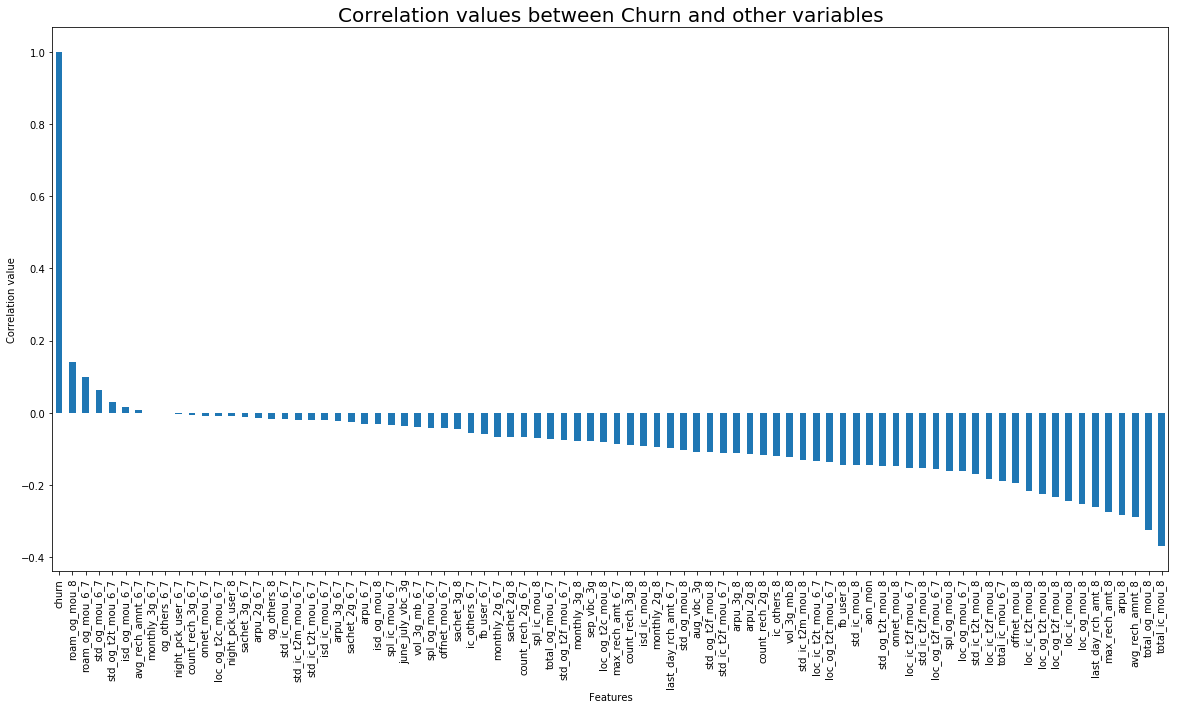

In [87]:
#CHURN CORRELATION WITH OTHER COLUMNS
plt.figure(figsize=(20,10))
master_df.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

#legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.title("Correlation values between Churn and other variables",fontsize=20)
plt.xlabel("Features",fontsize=10)
plt.ylabel("Correlation value",fontsize=10)
plt.show()

<b> roam_og_mou_8, roam_og_mou_6_7, std_og_mou_6_7,std_og_t2t_mou_6_7, isd_og_mout_6_7, avg_rech_amt_6_7 are positively correlated while others are either negatively or of no correlation.

# Test Train Split

<b> As Churn customers are less than non-churn customers, splitting data between customers so that sufficient amount of Churn customers are present in Training and Test data for a proper analysis   

In [88]:
master_df_0=master_df[master_df.churn==0]
master_df_1=master_df[master_df.churn==1]

In [89]:
master_df_1.shape

(2609, 84)

In [90]:
from sklearn.model_selection import train_test_split

In [91]:
train_0,test_0=train_test_split(master_df_0,test_size=0.2,random_state=100)
train_1,test_1=train_test_split(master_df_1,test_size=0.2,random_state=100)

In [92]:
train_1.shape

(2087, 84)

In [93]:
test_1.shape

(522, 84)

In [94]:
train=pd.concat([train_0,train_1],ignore_index=True)
test=pd.concat([test_0,test_1],ignore_index=True)

In [95]:
test.shape

(6001, 84)

# SMOTE Transform

In [96]:
smot=SMOTE(sampling_strategy=1.0,random_state=2)

In [97]:
y_train=train['churn']
X_train=train.drop(columns='churn')

In [98]:
y_train.value_counts()

0    21912
1     2087
Name: churn, dtype: int64

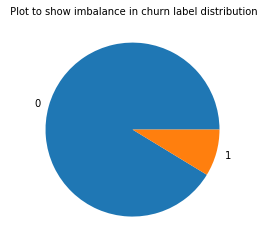

In [99]:
plt.pie(y_train.value_counts(),labels=y_train.value_counts().index)
plt.title(" Plot to show imbalance in churn label distribution",fontsize=10)
plt.show()

In [100]:
X_train,y_train=smot.fit_sample(X_train,y_train)

In [101]:
y_train.value_counts()

1    21912
0    21912
Name: churn, dtype: int64

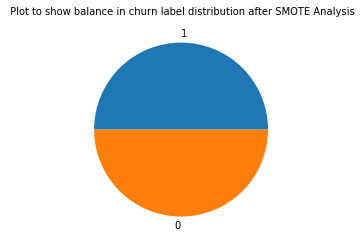

In [102]:
plt.pie(y_train.value_counts(),labels=y_train.value_counts().index)
plt.title(" Plot to show balance in churn label distribution after SMOTE Analysis",fontsize=10)
plt.show()

# Scaling Data

In [103]:
from sklearn.preprocessing import StandardScaler

In [104]:
scaler=StandardScaler()
scaled_df=pd.DataFrame(scaler.fit_transform(X_train))
scaled_df.columns=X_train.columns
X_train=scaled_df

In [105]:
X_train.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,std_og_t2f_mou_8,...,night_pck_user_6_7,monthly_2g_6_7,sachet_2g_6_7,monthly_3g_6_7,sachet_3g_6_7,fb_user_6_7,june_july_vbc_3g,aon_mon,avg_rech_amnt_6_7,avg_rech_amnt_8
0,1.024282,-0.209250,1.180224,-0.615335,-0.723513,0.521361,-0.414998,-0.627433,1.097425,-0.3662,...,-0.074049,-0.394948,-0.365203,-0.472414,-0.265877,-0.699039,-0.597706,-0.189694,1.222406,1.775124
1,-0.895632,0.413799,-0.978737,-0.615335,1.281825,-0.691050,-0.414998,0.159190,-0.726051,-0.3662,...,-0.074049,-0.394948,-0.365203,-0.472414,-0.265877,-0.699039,-0.597706,0.053028,0.301510,0.502486
2,1.945060,1.016831,2.093201,-0.615335,1.770926,1.297148,-0.414998,2.196130,0.294828,-0.3662,...,-0.074049,-0.394948,-0.365203,2.237043,3.948933,1.735847,2.172876,-1.317539,0.690438,1.452448
3,1.355228,1.373346,1.317465,2.082425,0.705606,1.263444,2.596492,-0.434465,1.004100,-0.3662,...,-0.074049,-0.394948,-0.365203,2.237043,-0.265877,0.921135,1.417767,0.653341,-0.482334,0.488405
4,-0.296406,0.855523,-0.564082,-0.615335,1.659649,1.149528,-0.414998,0.909331,-0.726051,-0.3662,...,-0.074049,-0.394948,-0.365203,-0.472414,-0.265877,-0.699039,-0.597706,0.947769,-1.215198,1.243680


Transforming Test Data

In [106]:
y_test=test['churn']
X_test=test.drop(columns='churn')
scaled_df=pd.DataFrame(scaler.transform(X_test))
scaled_df.columns=X_test.columns
X_test=scaled_df

# PCA

<b> Conducting PCA analysis to derive features with which explains 95% variance in data to determine best fit model to predict churn customers

In [107]:
from sklearn.decomposition import PCA

In [108]:
pca = PCA(random_state=42)

In [109]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [110]:
pca.components_

array([[ 1.96154637e-01,  1.42783759e-01,  1.70925014e-01, ...,
         7.27507692e-02,  5.70651734e-02,  1.59871646e-01],
       [-1.84932253e-02, -1.23454033e-01, -9.80187788e-02, ...,
        -1.91879764e-02,  4.70706291e-02,  4.37670381e-02],
       [ 6.83058665e-02,  5.28378160e-02, -8.17221445e-03, ...,
        -1.48200118e-01, -4.43950813e-02, -4.19621591e-02],
       ...,
       [ 4.27567962e-02,  1.18005483e-01,  1.31741166e-02, ...,
         1.42001838e-03,  9.22526781e-03, -1.32336329e-02],
       [-8.95217843e-03,  3.10714316e-03,  3.78247900e-04, ...,
        -9.81053185e-04,  5.94679679e-05,  1.02661654e-02],
       [-3.51068480e-03,  1.04742733e-03,  8.01628305e-03, ...,
         7.58242307e-04, -1.87031212e-04,  1.29581241e-02]])

In [111]:
pca.explained_variance_ratio_

array([1.88732251e-01, 1.32982842e-01, 6.97372973e-02, 4.17505564e-02,
       3.97736445e-02, 3.60652683e-02, 3.13858616e-02, 2.52496799e-02,
       2.44500006e-02, 2.17131272e-02, 2.10378207e-02, 1.83149106e-02,
       1.60026462e-02, 1.49511841e-02, 1.42266421e-02, 1.32820470e-02,
       1.29220117e-02, 1.23715810e-02, 1.21300087e-02, 1.15663135e-02,
       1.09084141e-02, 1.05328425e-02, 1.03387473e-02, 1.02201557e-02,
       9.86461311e-03, 9.11819568e-03, 8.64467511e-03, 8.52393212e-03,
       7.89204124e-03, 7.76859769e-03, 7.53841654e-03, 7.31842401e-03,
       6.97745556e-03, 6.74634959e-03, 6.63239779e-03, 6.37962531e-03,
       6.22521582e-03, 5.94031538e-03, 5.86455519e-03, 5.44579313e-03,
       5.05513773e-03, 4.74769542e-03, 4.59072655e-03, 4.52742365e-03,
       4.22519269e-03, 4.13763445e-03, 3.77414304e-03, 3.56207784e-03,
       3.46815959e-03, 3.29497005e-03, 3.13117567e-03, 3.07512889e-03,
       2.78960248e-03, 2.68218534e-03, 2.47995690e-03, 2.23094294e-03,
      

In [112]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

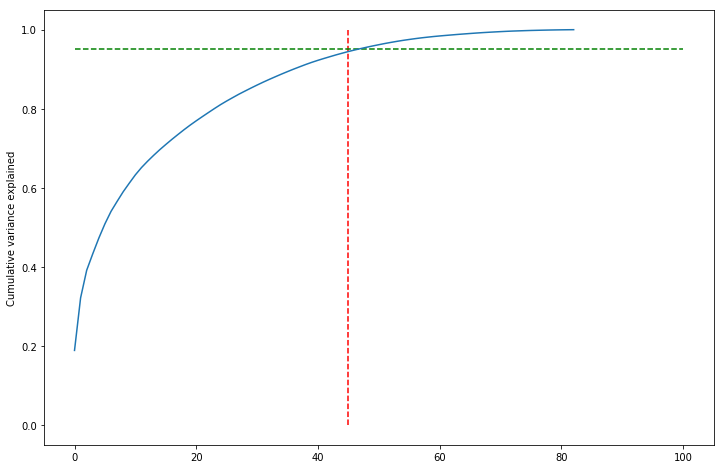

In [113]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=45, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=100, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [114]:
from sklearn.decomposition import IncrementalPCA

In [115]:
pca_final = IncrementalPCA(n_components=45)

In [116]:
df_train_pca = pca_final.fit_transform(X_train)

In [117]:
df_train_pca.shape

(43824, 45)

In [118]:
corrmat = np.corrcoef(df_train_pca.transpose())

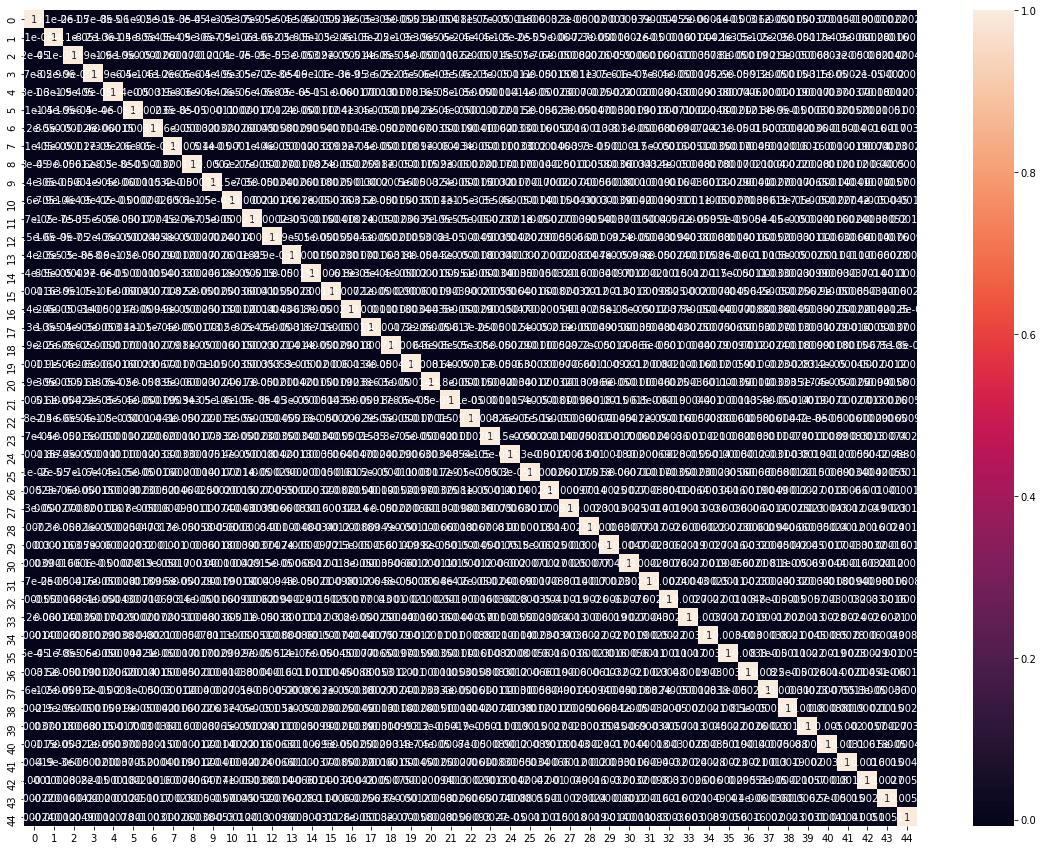

In [119]:
plt.figure(figsize=[20,15])
sns.heatmap(corrmat, annot=True)

<b> Transforming Test data using PCA 

In [120]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(6001, 45)

# Creating data frame to hold overall results of model analysis

In [121]:
overAllModelPerformance=pd.DataFrame(columns=['model','sensitivity','specitivity','AUC'])

# Evaluating models for better predicion

<b> As model prediction asks for improving prediction of customers who 'Churn', we will be trying to maximize sensitivity as part of model building process including tuning cutoff value so that sensitivity can be improved, with little impact to specitivity(predict Non-Churn Customers) 

## 1) Logistic Regression

In [122]:
lr=LogisticRegression(max_iter=1000)

In [123]:
lr.fit(df_train_pca,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Tuning for Cutoff

In [124]:
results_df=pd.DataFrame(columns=['sensitivity','specitivity','AUC'])

In [125]:
for i in range(1,10):  
  y_pred= lr.predict_proba(df_train_pca)
  y_pred=y_pred[:,1]
  y_pred=[1 if it>(i/10) else 0 for it in y_pred ]
  # check sensitivity and specificity
  sensitivity, specificity, _ = sensitivity_specificity_support(y_train, y_pred, average='binary')
  #print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

  # check area under curve
  y_pred_prob =  lr.predict_proba(df_train_pca)[:, 1]
  #print("AUC:    \t", round(metrics.roc_auc_score(y_test, y_pred_prob),2))
  results_df.loc[i,:]=[round(sensitivity, 2),round(specificity, 2),round(metrics.roc_auc_score(y_train, y_pred_prob),2)]

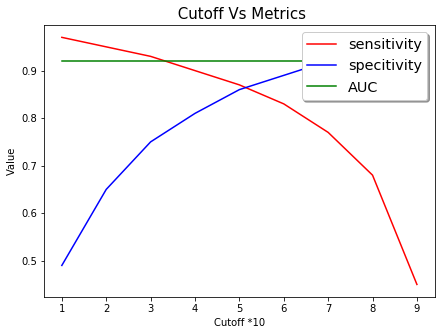

In [126]:
plt.figure(figsize=(7,5))
plt.plot(results_df.index,results_df.sensitivity,color='red',label="sensitivity")
plt.plot(results_df.index,results_df.specitivity,color='blue',label="specitivity")
plt.plot(results_df.index,results_df.AUC,color='Green',label="AUC")
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.title(" Cutoff Vs Metrics", fontsize=15)
plt.xlabel("Cutoff *10")
plt.ylabel("Value")
plt.show()

<b> Cutoff of 0.5 seems to improve sensitivity and with low impact to specitivity

In [127]:
y_pred=lr.predict(df_train_pca)

sensitivity, specificity, _ = sensitivity_specificity_support(y_train, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = lr.predict_proba(df_train_pca)[:, 1]
print("AUC:    \t", round(metrics.roc_auc_score(y_train, y_pred_prob),2))

Sensitivity: 	0.87
Specificity: 	0.86
AUC:    	 0.92


### Predicting on Test Data

In [128]:
y_pred=lr.predict(df_test_pca)

In [129]:
confusion_matrix(y_test,y_pred)

array([[4679,  800],
       [  80,  442]], dtype=int64)

In [130]:
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = lr.predict_proba(df_test_pca)[:, 1]
print("AUC:    \t", round(metrics.roc_auc_score(y_test, y_pred_prob),2))

Sensitivity: 	0.85
Specificity: 	0.85
AUC:    	 0.92


In [131]:
overAllModelPerformance.loc[0,:]=['Logistic',round(sensitivity, 2),round(specificity, 2), round(metrics.roc_auc_score(y_test, y_pred_prob),2)]

In [132]:
overAllModelPerformance

,model,sensitivity,specitivity,AUC
0,Logistic,0.85,0.85,0.92


## 2) Decision Tree Classifier

In [133]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [134]:
#k-fold=5
n_folds = 5

# parameters in the range 1 to 30
parameters = {'max_depth': range(1, 25,5),
              'min_samples_leaf': [100,400],
              'min_samples_split': [200,500],
             }
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)
                               
# Training Data Tree Fit
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="recall",
                   return_train_score=True)
tree.fit(df_train_pca,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=100,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': range(1, 25, 5),
                        

In [135]:
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.178547,0.007688,0.003790,0.000399,1,100,200,"{'max_depth': 1, 'min_samples_leaf': 100, 'min...",0.697170,0.706298,...,0.705092,0.008837,17,0.707644,0.703708,0.703748,0.702607,0.708329,0.705207,0.002316
1,0.172340,0.001830,0.003393,0.000490,1,100,500,"{'max_depth': 1, 'min_samples_leaf': 100, 'min...",0.697170,0.706298,...,0.705092,0.008837,17,0.707644,0.703708,0.703748,0.702607,0.708329,0.705207,0.002316
2,0.178730,0.003637,0.003988,0.000630,1,400,200,"{'max_depth': 1, 'min_samples_leaf': 400, 'min...",0.697170,0.706298,...,0.705092,0.008837,17,0.707644,0.703708,0.703748,0.702607,0.708329,0.705207,0.002316
3,0.264092,0.050366,0.005392,0.001016,1,400,500,"{'max_depth': 1, 'min_samples_leaf': 400, 'min...",0.697170,0.706298,...,0.705092,0.008837,17,0.707644,0.703708,0.703748,0.702607,0.708329,0.705207,0.002316
4,1.160717,0.067707,0.005187,0.000400,6,100,200,"{'max_depth': 6, 'min_samples_leaf': 100, 'min...",0.827932,0.814240,...,0.840999,0.017196,4,0.852139,0.826241,0.859148,0.855554,0.849743,0.848565,0.011605


In [136]:
print('We can get recall of',tree.best_score_,'using',tree.best_params_)

We can get recall of 0.8560596608218155 using {'max_depth': 16, 'min_samples_leaf': 100, 'min_samples_split': 200}


In [137]:
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100,max_depth=16,min_samples_leaf=100, min_samples_split= 200)
dtree.fit(df_train_pca,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=16, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')

### Tuning for Cutoff

In [138]:
results_df=pd.DataFrame(columns=['sensitivity','specitivity','AUC'])

In [139]:
for i in range(1,10):  
  y_pred= dtree.predict_proba(df_train_pca)
  y_pred=y_pred[:,1]
  y_pred=[1 if it>(i/10) else 0 for it in y_pred ]
  # check sensitivity and specificity
  sensitivity, specificity, _ = sensitivity_specificity_support(y_train, y_pred, average='binary')
  #print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

  # check area under curve
  y_pred_prob =  dtree.predict_proba(df_train_pca)[:, 1]
  #print("AUC:    \t", round(metrics.roc_auc_score(y_test, y_pred_prob),2))
  results_df.loc[i,:]=[round(sensitivity, 2),round(specificity, 2),round(metrics.roc_auc_score(y_train, y_pred_prob),2)]

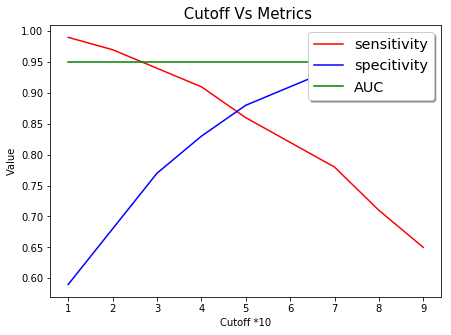

In [140]:
plt.figure(figsize=(7,5))
plt.plot(results_df.index,results_df.sensitivity,color='red',label="sensitivity")
plt.plot(results_df.index,results_df.specitivity,color='blue',label="specitivity")
plt.plot(results_df.index,results_df.AUC,color='Green',label="AUC")
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.title(" Cutoff Vs Metrics", fontsize=15)
plt.xlabel("Cutoff *10")
plt.ylabel("Value")
plt.show()

<b> Cutoff of 0.4 seems to improve sensitivity and with low impact to specitivity

In [141]:
y_pred=dtree.predict_proba(df_train_pca)
y_pred=y_pred[:,1]
y_pred=[1 if it>0.4 else 0 for it in y_pred ]

sensitivity, specificity, _ = sensitivity_specificity_support(y_train, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = dtree.predict_proba(df_train_pca)[:, 1]
print("AUC:    \t", round(metrics.roc_auc_score(y_train, y_pred_prob),2))

Sensitivity: 	0.91
Specificity: 	0.83
AUC:    	 0.95


### Predicting on Test Data

In [142]:
y_pred=dtree.predict_proba(df_test_pca)
y_pred=y_pred[:,1]
y_pred=[1 if it>0.4 else 0 for it in y_pred ]

In [143]:
confusion_matrix(y_test,y_pred)

array([[4453, 1026],
       [  96,  426]], dtype=int64)

In [144]:
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = lr.predict_proba(df_test_pca)[:, 1]
print("AUC:    \t", round(metrics.roc_auc_score(y_test, y_pred_prob),2))

Sensitivity: 	0.82
Specificity: 	0.81
AUC:    	 0.92


In [145]:
overAllModelPerformance.loc[1,:]=['DecisionTree',round(sensitivity, 2),round(specificity, 2), round(metrics.roc_auc_score(y_test, y_pred_prob),2)]

In [146]:
overAllModelPerformance

,model,sensitivity,specitivity,AUC
0,Logistic,0.85,0.85,0.92
1,DecisionTree,0.82,0.81,0.92


# 3) XGBoost

In [147]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics

C:\ProgramData\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\ProgramData\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [148]:
# hyperparameter tuning with XGBoost

# creating a KFold object 
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6,0.9], 
             'subsample': [0.3, 0.6,0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs=6)   

In [149]:
model_cv.fit(df_train_pca, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed: 10.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimato...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=Non

In [150]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,62.284293,0.617571,0.196602,0.013931,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.858284,0.915335,0.914214,...,0.902883,0.022538,8,0.919624,0.913063,0.908095,0.909978,0.911865,0.912525,0.003930
1,86.901665,2.304374,0.231857,0.021721,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.859653,0.914423,0.916724,...,0.903431,0.022090,7,0.919852,0.910839,0.911575,0.911290,0.909241,0.912559,0.003734
2,100.811247,2.796638,0.242252,0.021508,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.857371,0.911228,0.912389,...,0.901696,0.022452,9,0.918026,0.912037,0.910434,0.911005,0.912208,0.912742,0.002722
3,64.579535,4.524005,0.233890,0.034909,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.857827,0.931082,0.934063,...,0.918719,0.030510,5,0.944723,0.938677,0.935707,0.936163,0.941015,0.939257,0.003331
4,79.165517,1.536088,0.206254,0.006362,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.860794,0.938156,0.942049,...,0.924606,0.032297,4,0.956418,0.946948,0.947287,0.946945,0.946606,0.948841,0.003795


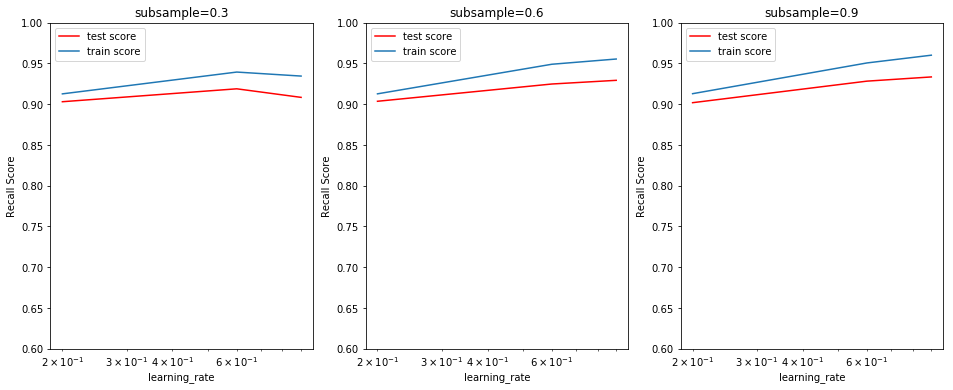

In [151]:
# # plotting
plt.figure(figsize=(16,6))

param_grid = {'learning_rate': [0.2, 0.6,0.9], 
             'subsample': [0.3, 0.6,0.9]} 


for n, subsample in enumerate(param_grid['subsample']):
    

    # subplot 1/n
    plt.subplot(1,len(param_grid['subsample']), n+1)
    df = cv_results[cv_results['param_subsample']==subsample]

    plt.plot(df["param_learning_rate"], df["mean_test_score"],color='red')
    plt.plot(df["param_learning_rate"], df["mean_train_score"])
    plt.xlabel('learning_rate')
    plt.ylabel('Recall Score')
    plt.title("subsample={0}".format(subsample))
    plt.ylim([0.60, 1])
    plt.legend(['test score', 'train score'], loc='upper left')
    plt.xscale('log')

In [152]:
print('We can get recall of',model_cv.best_score_,'using',model_cv.best_params_)

We can get recall of 0.9332769351899319 using {'learning_rate': 0.9, 'subsample': 0.9}


In [153]:
# chosen hyperparameters
# 'objective':'binary:logistic' outputs probability rather than label, which we need for auc
params = {'learning_rate': 0.9,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.9,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params)
model.fit(df_train_pca, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic',
              params={'learning_rate': 0.9, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.9},
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method=None, validate_parameters=False,
              verbosity=None)

### Tuning for Cutoff

In [154]:
results_df=pd.DataFrame(columns=['sensitivity','specitivity','AUC'])

In [155]:
for i in range(1,10):  
  y_pred= model.predict_proba(df_train_pca)
  y_pred=y_pred[:,1]
  y_pred=[1 if it>(i/10) else 0 for it in y_pred ]
  # check sensitivity and specificity
  sensitivity, specificity, _ = sensitivity_specificity_support(y_train, y_pred, average='binary')
  #print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

  # check area under curve
  y_pred_prob =  model.predict_proba(df_train_pca)[:, 1]
  #print("AUC:    \t", round(metrics.roc_auc_score(y_test, y_pred_prob),2))
  results_df.loc[i,:]=[round(sensitivity, 2),round(specificity, 2),round(metrics.roc_auc_score(y_train, y_pred_prob),2)]

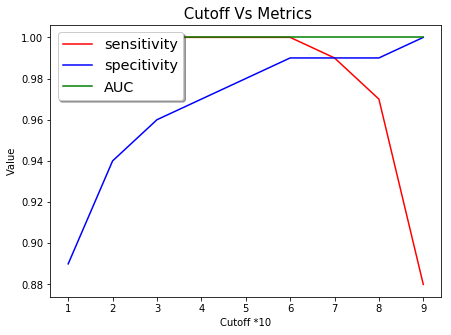

In [156]:
plt.figure(figsize=(7,5))
plt.plot(results_df.index,results_df.sensitivity,color='red',label="sensitivity")
plt.plot(results_df.index,results_df.specitivity,color='blue',label="specitivity")
plt.plot(results_df.index,results_df.AUC,color='Green',label="AUC")
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.title(" Cutoff Vs Metrics", fontsize=15)
plt.xlabel("Cutoff *10")
plt.ylabel("Value")
plt.show()

<b> Cut-off of 0.6 seems to be good maintaining high sensitvity and specitivity, but since this is training data and having this high cutoff can cause imbalance while predicting test data for Churn customers, hence proceeding with 0.5 cutoff which is also having similar performance

In [157]:
y_pred=model.predict_proba(df_train_pca)
y_pred=y_pred[:,1]
y_pred=[1 if it>0.5 else 0 for it in y_pred ]

sensitivity, specificity, _ = sensitivity_specificity_support(y_train, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(df_train_pca)[:, 1]
print("AUC:    \t", round(metrics.roc_auc_score(y_train, y_pred_prob),2))

Sensitivity: 	1.0
Specificity: 	0.98
AUC:    	 1.0


### Predicting on Test Data

In [158]:
y_pred = model.predict_proba(df_test_pca)
y_pred=y_pred[:,1]
y_pred=[1 if it>0.5 else 0 for it in y_pred]

In [159]:
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(df_test_pca)[:, 1]
print("AUC:    \t", round(metrics.roc_auc_score(y_test, y_pred_prob),2))

Sensitivity: 	0.71
Specificity: 	0.94
AUC:    	 0.92


<b> For XGBoost the cross validated training score for Sensitivity and Specitivity are good, but the test scores looks to be low 

In [160]:
confusion_matrix(y_test,y_pred)

array([[5153,  326],
       [ 152,  370]], dtype=int64)

In [161]:
overAllModelPerformance.loc[2,:]=['XGBoost',round(sensitivity, 2),round(specificity, 2), round(metrics.roc_auc_score(y_test, y_pred_prob),2)]

In [162]:
overAllModelPerformance

,model,sensitivity,specitivity,AUC
0,Logistic,0.85,0.85,0.92
1,DecisionTree,0.82,0.81,0.92
2,XGBoost,0.71,0.94,0.92


# 4) Random Forest

In [163]:
from sklearn.ensemble import RandomForestClassifier

In [164]:
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters1 = {
    'max_depth': [4,8],
    'min_samples_leaf': [100,400],
    'min_samples_split': [200,500],
    'n_estimators': [100,200], 
    'max_features': [5,10]
}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf_grid = GridSearchCV(rf, parameters1, 
                    cv=n_folds, 
                   scoring="recall",
                   verbose = 1,
                   return_train_score=True,
                   n_jobs=6)
rf_grid.fit(df_train_pca, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 160 out of 160 | elapsed: 38.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [165]:
# scores of GridSearch CV
scores = rf_grid.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,27.749589,0.215651,0.312907,0.017133,4,5,100,200,100,"{'max_depth': 4, 'max_features': 5, 'min_sampl...",...,0.807044,0.028405,14,0.788648,0.798289,0.820640,0.821096,0.819452,0.809625,0.013550
1,57.308066,0.652637,0.620509,0.058353,4,5,100,200,200,"{'max_depth': 4, 'max_features': 5, 'min_sampl...",...,0.808094,0.018095,12,0.819509,0.804963,0.817217,0.814479,0.805077,0.812249,0.006114
2,28.301732,0.420739,0.279803,0.035789,4,5,100,500,100,"{'max_depth': 4, 'max_features': 5, 'min_sampl...",...,0.803668,0.019997,22,0.805134,0.800000,0.803811,0.812425,0.811979,0.806670,0.004824
3,56.062890,0.124414,0.566600,0.042658,4,5,100,500,200,"{'max_depth': 4, 'max_features': 5, 'min_sampl...",...,0.802893,0.009721,24,0.821506,0.806275,0.798334,0.798962,0.807245,0.806464,0.008358
4,27.132296,0.338343,0.294547,0.017119,4,5,400,200,100,"{'max_depth': 4, 'max_features': 5, 'min_sampl...",...,0.807685,0.016804,13,0.808557,0.823845,0.805979,0.803012,0.815744,0.811427,0.007504


In [166]:
print('We can get recall of',rf_grid.best_score_,'using',rf_grid.best_params_)

We can get recall of 0.8342449505907071 using {'max_depth': 8, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 200}


In [167]:
rf = RandomForestClassifier(bootstrap=True,max_depth= 8, max_features= 10, 
                            min_samples_leaf=100, min_samples_split= 200, n_estimators=200)

rf.fit(df_train_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=200,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Tuning for Cutoff

In [178]:
results_df=pd.DataFrame(columns=['sensitivity','specitivity','AUC'])

In [179]:
for i in range(1,10):  
  y_pred=rf.predict_proba(df_train_pca)
  y_pred=y_pred[:,1]
  y_pred=[1 if it>(i/10) else 0 for it in y_pred ]
  # check sensitivity and specificity
  sensitivity, specificity, _ = sensitivity_specificity_support(y_train, y_pred, average='binary')
  #print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

  # check area under curve
  y_pred_prob = rf.predict_proba(df_train_pca)[:, 1]
  #print("AUC:    \t", round(metrics.roc_auc_score(y_test, y_pred_prob),2))
  results_df.loc[i,:]=[round(sensitivity, 2),round(specificity, 2),round(metrics.roc_auc_score(y_train, y_pred_prob),2)]

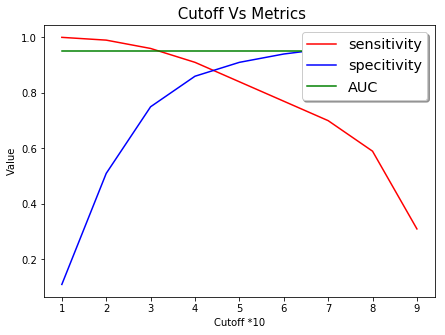

In [180]:
plt.figure(figsize=(7,5))
plt.plot(results_df.index,results_df.sensitivity,color='red',label="sensitivity")
plt.plot(results_df.index,results_df.specitivity,color='blue',label="specitivity")
plt.plot(results_df.index,results_df.AUC,color='Green',label="AUC")
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.title(" Cutoff Vs Metrics", fontsize=15)
plt.xlabel("Cutoff *10")
plt.ylabel("Value")
plt.show()

<b> Cut off of 0.4 seems to maintain good balance between sensitivity and specitivity.

### Predicting on Test Data

In [181]:
y_pred = rf.predict_proba(df_test_pca)
y_pred=y_pred[:,1]
y_pred=[1 if it>0.4 else 0 for it in y_pred]

In [182]:
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = rf.predict_proba(df_test_pca)[:, 1]
print("AUC:    \t", round(metrics.roc_auc_score(y_test, y_pred_prob),2))

Sensitivity: 	0.85
Specificity: 	0.85
AUC:    	 0.92


In [183]:
confusion_matrix(y_test,y_pred)

array([[4669,  810],
       [  76,  446]], dtype=int64)

In [184]:
overAllModelPerformance.loc[3,:]=['RandomForest',round(sensitivity, 2),round(specificity, 2), round(metrics.roc_auc_score(y_test, y_pred_prob),2)]

# Model Performance Evaluation

In [185]:
overAllModelPerformance

,model,sensitivity,specitivity,AUC
0,Logistic,0.85,0.85,0.92
1,DecisionTree,0.82,0.81,0.92
2,XGBoost,0.71,0.94,0.92
3,RandomForest,0.85,0.85,0.92


Text(0.5, 1.0, 'Bar Chart For R2 of Different Models')

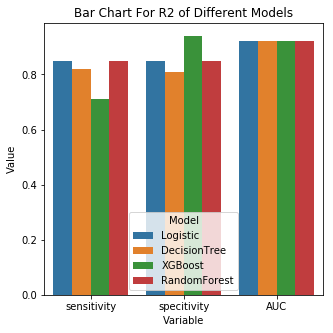

In [186]:
plt.figure(figsize=(5,5))
tidy = overAllModelPerformance.melt(id_vars='model').rename(columns=str.title)
plot=sns.barplot(x='Variable', y='Value', hue='Model', data=tidy)
plot.set_title("Bar Chart For R2 of Different Models")

<b>Both Random Forest and Logistic Regression looks to have similar results of Sensitivity and Specitivity for this analysis. However for better explanation of variables relation to target variable, logistic regression shall be chosen for prediction.

# Finding Most important predictors using Logistic Regression

<b> Logistic Regression fusing Stats Model can be used for predicting important predictors. In addition it also helps in determining how the predictor has impact on outcome

In [187]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Using RFE To filter out most important columns

In [188]:
logreg = LogisticRegression(max_iter=1000)
rfe = RFE(logreg, 10)             # running RFE with 10 variables as output
rfe = rfe.fit(X_train, y_train)

In [189]:
col = X_train.columns[rfe.support_]

In [190]:
X_train_RFE=X_train[col]
X_test_RFE=X_test[col]

## Using Stats Model to determine important features

In [191]:
X_train_sm = sm.add_constant(X_train_RFE)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [192]:
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43824
Model:                            GLM   Df Residuals:                    43813
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14695.
Date:                Mon, 18 May 2020   Deviance:                       29389.
Time:                        21:32:21   Pearson chi2:                 5.31e+04
No. Iterations:                     7   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.0642      0.016     -3.940      0.000      -0.096      -0.032
roam_og_mou_8          0.6571      0.016     42.367      0.000       0.627       0.687
total_og_mou_8        -0.8509      0.024    -35.930      0.000      -0.897      -0.804
loc_ic_mou_8           1.2544      0.034     37.225      0.000       1.188       1.320
std_ic_mou_8           0.3893      0.019     20.556      0.000       0.352       0.426
total_ic_mou_8        -2.5657      0.043    -59.675      0.000      -2.650      -2.481
last_day_rch_amt_8    -0.5767      0.017    -34.319      0.000      -0.610      -0.544
count_rech_3g_8        0.0744      0.024      3.135      0.002       0.028       0.121
fb_user_8             -0.6026      0.025    -24.467      0.000      -0.651      -0.554
sep_vbc_3g            -0.5440      0.027    -20.367      0.000      -0.596      -0.492
arpu_6_7               0.7293      0.019     37.496      0.000       0.691       0.767
======================================================================================
"""

In [193]:
y_pred=res.predict(X_train_sm)
y_pred=y_pred=[1 if it>0.5 else 0 for it in y_pred]
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_train, y_pred, average='binary')
print("Train Sensitivity: \t", round(sensitivity, 2), "\n", "Train Specificity: \t", round(specificity, 2), sep='')

Train Sensitivity: 	0.85
Train Specificity: 	0.87


In [194]:
X_test_sm = sm.add_constant(X_test_RFE)

In [195]:
y_pred=res.predict(X_test_sm)
y_pred=y_pred=[1 if it>0.4 else 0 for it in y_pred]
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Test Sensitivity: \t", round(sensitivity, 2), "\n", "Test Specificity: \t", round(specificity, 2), sep='')

Test Sensitivity: 	0.89
Test Specificity: 	0.83


### Checking for VIF between columns

In [196]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,total_ic_mou_8,6.19
2,loc_ic_mou_8,4.20
1,total_og_mou_8,2.72
7,fb_user_8,2.17
6,count_rech_3g_8,2.03
3,std_ic_mou_8,1.49
5,last_day_rch_amt_8,1.43
0,roam_og_mou_8,1.40
9,arpu_6_7,1.37
8,sep_vbc_3g,1.08


<b>All features have low P value.
<br>Now "total_ic_mou_8" is having high VIF, hence considering to drop this feature

## Removing 'total_ic_mou_8' having high VIF value

In [197]:
X_train_RFE=X_train_RFE.drop(columns=['total_ic_mou_8'])
X_train_sm = sm.add_constant(X_train_RFE)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [198]:
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43824
Model:                            GLM   Df Residuals:                    43814
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17093.
Date:                Mon, 18 May 2020   Deviance:                       34187.
Time:                        21:32:22   Pearson chi2:                 5.05e+04
No. Iterations:                     7   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1040      0.015     -7.082      0.000      -0.133      -0.075
roam_og_mou_8          0.5012      0.016     31.816      0.000       0.470       0.532
total_og_mou_8        -1.5139      0.021    -70.865      0.000      -1.556      -1.472
loc_ic_mou_8          -0.3221      0.018    -17.651      0.000      -0.358      -0.286
std_ic_mou_8           0.0736      0.017      4.454      0.000       0.041       0.106
last_day_rch_amt_8    -0.7197      0.016    -45.718      0.000      -0.751      -0.689
count_rech_3g_8        0.2353      0.022     10.563      0.000       0.192       0.279
fb_user_8             -0.7776      0.024    -32.849      0.000      -0.824      -0.731
sep_vbc_3g            -0.5959      0.026    -23.247      0.000      -0.646      -0.546
arpu_6_7               0.6889      0.018     39.123      0.000       0.654       0.723
======================================================================================
"""

In [199]:
y_pred=res.predict(X_train_sm)
y_pred=y_pred=[1 if it>0.4 else 0 for it in y_pred]
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_train, y_pred, average='binary')
print("Train Sensitivity: \t", round(sensitivity, 2), "\n", "Train Specificity: \t", round(specificity, 2), sep='')

Train Sensitivity: 	0.88
Train Specificity: 	0.78


In [200]:
X_test_RFE=X_test_RFE.drop(columns=['total_ic_mou_8'])
X_test_sm = sm.add_constant(X_test_RFE)

y_pred=res.predict(X_test_sm)
y_pred=y_pred=[1 if it>0.4 else 0 for it in y_pred]
# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Test Sensitivity: \t", round(sensitivity, 2), "\n", "Test Specificity: \t", round(specificity, 2), sep='')

Test Sensitivity: 	0.88
Test Specificity: 	0.77


In [201]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_test_RFE.columns
vif['VIF'] = [variance_inflation_factor(X_test_RFE.values, i) for i in range(X_test_RFE.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,total_og_mou_8,2.10
6,fb_user_8,1.93
5,count_rech_3g_8,1.85
2,loc_ic_mou_8,1.53
8,arpu_6_7,1.50
3,std_ic_mou_8,1.31
4,last_day_rch_amt_8,1.25
0,roam_og_mou_8,1.13
7,sep_vbc_3g,1.08


<b> Now that VIF and P values are low and in acceptable range.
    <br> Though specitivity is low for this model, we only need important Independent features which impact customers for churn. Hence proceeding with this model

## Extracting Most Important Features with its effect

In [202]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                43824
Model:                            GLM   Df Residuals:                    43814
Model Family:                Binomial   Df Model:                            9
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17093.
Date:                Mon, 18 May 2020   Deviance:                       34187.
Time:                        21:32:55   Pearson chi2:                 5.05e+04
No. Iterations:                     7   Covariance Type:             nonrobust
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -0.1040      0.015     -7.082      0.000      -0.133      -0.075
roam_og_mou_8          0.5012      0.016     31.816      0.000       0.470       0.532
total_og_mou_8        -1.5139      0.021    -70.865      0.000      -1.556      -1.472
loc_ic_mou_8          -0.3221      0.018    -17.651      0.000      -0.358      -0.286
std_ic_mou_8           0.0736      0.017      4.454      0.000       0.041       0.106
last_day_rch_amt_8    -0.7197      0.016    -45.718      0.000      -0.751      -0.689
count_rech_3g_8        0.2353      0.022     10.563      0.000       0.192       0.279
fb_user_8             -0.7776      0.024    -32.849      0.000      -0.824      -0.731
sep_vbc_3g            -0.5959      0.026    -23.247      0.000      -0.646      -0.546
arpu_6_7               0.6889      0.018     39.123      0.000       0.654       0.723
======================================================================================
"""

In [203]:
most_important_features=res.params

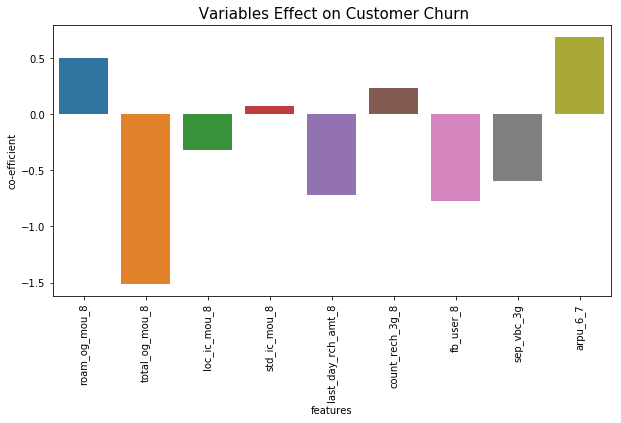

In [204]:
plt.figure(figsize=(10,5))
ax=sns.barplot(x=most_important_features.index[1:],y=most_important_features.values[1:])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(" Variables Effect on Customer Churn", fontsize=15)
plt.xlabel("features")
plt.ylabel("co-efficient")
plt.show()

# Conclusion

<b> Below parameters looks to be most important predictors with rate of how they effect the prediction

In [205]:
most_important_features[1:]

roam_og_mou_8         0.501158
total_og_mou_8       -1.513886
loc_ic_mou_8         -0.322108
std_ic_mou_8          0.073561
last_day_rch_amt_8   -0.719685
count_rech_3g_8       0.235286
fb_user_8            -0.777600
sep_vbc_3g           -0.595918
arpu_6_7              0.688946
dtype: float64

## Strategies to manage customer churn:

<b>
1) Use Logistic Regression with cut off 0.4 to predict customers who churn<br>
    
2) As seen from EDA stage that customers who Churn mostly use Data Services than Call services, improve offers on call services for customers who churn, like removing std incoming call charges.<br>

3) As can be seen that roaming outgoing calls is having positive impact on customers for Churn. Considering reducing call cost for customers during roaming services or remove roaming charges <br>

4) Customers who churn looks to recharge more number of times in Action phase. Hence improving plans like 2months/3 months will help in reducing churn.<br>

5) Average Revenue per user looks to postively impact more for customers to churn, which means customers are getting less for money they spend. Creating more offers like Free Membership and other value added services shall help in customer churn